In [131]:
# Kiểm tra phiên bản của thư viện Keras (2.15.0).
!python -c 'import keras; print(keras.__version__)'

2.15.0


# MẠNG CONVOLUTIONAL NEURAL NETWORK (CNN)

Bài tập này, ta sẽ tiến hành cài đặt một trong những mạng `CNN` đầu tiên là LeNet. Kiến trúc của mạng LeNet được tóm tắt như sau:

![](LeNet.png)

Trong hình trên kiến trúc của mô hình được tóm tắt như sau:

**Lớp input**: chứa ảnh đầu vào
- Kích thước ảnh của tập MNIST là `28x28`. Do ảnh này là ảnh mức xám (không có màu) nên độ sâu bằng 1.

**Lớp convolution C1**: lớp biến đổi đặc trưng đầu tiên, sử dụng phép biến đổi convolution kết hợp với hàm kích hoạt.

- Phiên bản năm 1998 Yann Lecun sử dụng `6 filter` kích thước `3x3`, hàm kích hoạt `sigmoid`.

**Lớp pooling** hay subsampling S2: lớp làm giảm kích thước chiều không gian (chiều ngang và dọc).
- Phiên bản năm 1998 sử dụng filter `AveragePooling` với kích thước à `2x2`.

**Lớp convolution C3**: tương tự C1 nhưng số filter nhiều hơn *nhằm tạo ra các **đặc trưng cấp cao** kết hợp từ các đặc trưng cấp thấp trước đó*.
- Lớp này sử dụng `16 filter` kích thước `3x3` với hàm kích hoạt `sigmoid`.

**Lớp convolution S4**: tương tự như lớp S2.
- Ta sử dụng filter `AveragePooling`, kích thước filter là `2x2`.

**Lớp fully connected (kết nối đầu đủ) F5**: thực hiện phép nhân tuyến tính kết hợp với hàm kích hoạt. Các lớp F5 trở đi thực hiện chức năng phân loại (classify) đặc trưng đã rút trích từ các bước trước đó.
- Phiên bản này sử dụng hàm `sigmoid`. Số neuron output của lớp này là **120 neuron**.
- Lưu ý quan trọng: trước lớp F5, ta sẽ có "bước đệm" là `Flatten` để biến đặc trưng **từ dạng tensor thành dạng vector**.

**Lớp fully connected F6**: tương tự lớp F5.
- Số neuron output của lớp này là **84 neuron**, hàm kích hoạt `sigmoid`.

**Lớp output**: Tương tự như F5.
- Số neuron output của lớp này là **10 neuron**, sử dụng hàm `softmax` để đưa đặc trưng về không gian xác suất của các lớp đối tượng cần phân loại.

Bắt đầu tiến hành cài đặt thôi!

## 1. Chuẩn bị dữ liệu huấn luyện
Đầu tiên, ta sẽ sử dụng tập dữ liệu MNIST cho bài tập này. Trong `keras.datasets` có rất nhiều dữ liệu được đóng gói và chuẩn bị sẵn như `MNIST`, `CIFAR`, `Fashion MNIST`. Trong bài tập này, ta sẽ sử dụng tập dữ liệu `MNIST`:

In [132]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf


def fix_random_seed():
    np.random.seed(1)
    tf.random.set_seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Thông tin kích thước các biến trên: ")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Thông tin kích thước các biến trên: 
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [133]:
print('Ý nghĩa kích thước các biến trên: ')
print('Số mẫu train: {} mẫu'.format(x_train.shape[0]))
print('Số mẫu test: {} mẫu'.format(x_test.shape[0]))
print('Kích thước ảnh đầu vào: ', x_train.shape[1:])

Ý nghĩa kích thước các biến trên: 
Số mẫu train: 60000 mẫu
Số mẫu test: 10000 mẫu
Kích thước ảnh đầu vào:  (28, 28)


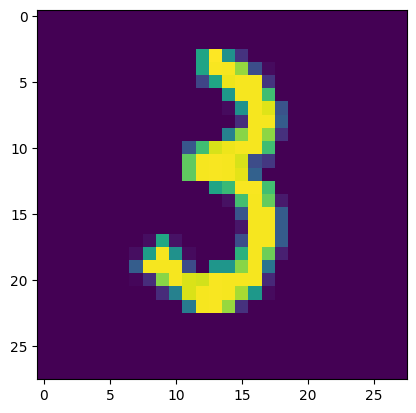

Nhãn (label) của ground-truth:  3


In [134]:
# Code block này hiển thị một mẫu dữ liệu train.
# Đây là việc NÊN LÀM khi bắt đầu với bất kỳ dữ liệu nào
# Ở đây ta sẽ load mẫu dữ liệu thứ 1234. Các bạn có thể thay đổi giá trị này tùy ý
import matplotlib.pyplot as plt

sample_id = 1234
plt.imshow(x_train[sample_id])
plt.show()
print('Nhãn (label) của ground-truth: ', y_train[sample_id])

## 2. Tiền xử lý dữ liệu
Việc chuẩn hóa dữ liệu bao gồm hai nhóm công việc chính:
* Đối với output `y`: chuyển đổi **từ dạng nhãn (label) sang dạng one-hot encoding**.
* Đối với input `x`: chuẩn hóa các giá trị mức sáng **từ [0-255] về đoạn [0-1]**. Bước này cải tiến tốc độ huấn luyện một cách đáng kể.

In [135]:
# Hàm này được sử dụng để chuyển đổi output từ dạng
# nhãn sang dạng one-hot vector
def onehot(y):
    oh = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]):
        oh[i, int(y[i])]=1
    return oh

In [136]:
from sklearn import preprocessing
import numpy as np

# Chuyển đổi từ dạng label sang dạng one-hot encoding
y_train_oh = onehot(y_train)
y_train_oh.shape

y_test_oh = onehot(y_test)
y_test_oh.shape

# Chuẩn hóa ảnh đầu vào về [0-1]
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [137]:
# Các bạn có thể xem dữ liệu trước và sau khi tiền xử lý
# Các bạn có thể thay đổi sample_id bằng số tùy ý
sample_id = 4321

print("`y` TRƯỚC khi biến đổi: ", y_train[sample_id])
print("`y` SAU khi biến đổi: ", y_train_oh[sample_id])

`y` TRƯỚC khi biến đổi:  0
`y` SAU khi biến đổi:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [138]:
print("`x` TRƯỚC khi biến đổi: ", x_train[sample_id])
print("`x` SAU khi biến đổi: ", x_train_norm[sample_id])

`x` TRƯỚC khi biến đổi:  [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   48 191 255 203   7   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  57
  172 252 247 196  43   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 104 252
  252 252  50   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 201 253 252
  252 202  51   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  

## 3. Cài đặt mạng CNN với kiến trúc LeNet

Import các thư viện Keras phục vụ cho việc cài đặt mô hình:

Đầu tiên, ta sẽ import các thư viện, module, hàm của `Keras`:
- `Input`: để nhận dữ liệu đầu vào cho mô hình
- `Conv2D`: biến đổi Convolution với activation
- `AveragePooling2D`: giảm kích thước đặc trưng
- `Dense`: hay còn gọi là lớp Fully Connected (Lớp kết nối đầy đủ), một thành phần quan trọng của các mô hình dựa trên mạng Neural Network.
- `Model`: đây là lớp đối tượng mô hình được sử dụng để đóng gói lớp đầu vào, đầu ra, sau đó huấn luyện với phương thức `fit` và dự đoán kết quả với `predict`.
- `load_model`: hàm sử dụng để load mô hình lên từ file

In [139]:
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten
from keras.models import load_model, Model
import keras

In [140]:
class LeNetCNN:
    # constructor
    def __init__(self):
        self.model = None

    # Định nghĩa kiến trúc của mô hình
    def build(self, input_dim):
        input = Input(shape=input_dim)  # input

        # Bước rút trích đặc trưng
        C1 = Conv2D(6, (3, 3), padding="same", activation="sigmoid")(input)
        S2 = AveragePooling2D(pool_size=(2, 2), padding="same")(C1)
        C3 = Conv2D(16, (3, 3), padding="same", activation="sigmoid")(S2)
        S4 = AveragePooling2D(pool_size=(2, 2), padding="same")(C3)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(S4)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, activation="sigmoid", use_bias=True)(flat)
        F6 = Dense(84, activation="sigmoid", use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output

        self.model = Model(input, output)

    # Huấn luyện mô hình
    def train(
        self, x_train, y_train
    ):  # x_train chinh la X, y_train chinh la ground-truth
        adam = keras.optimizers.Adam(learning_rate=0.01)
        self.model.compile(
            optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]
        )
        self.model.fit(x_train, y_train, epochs=10, batch_size=128)

    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

    # Đánh giá trên tập dữ liệu test
    def predict_and_eval(self, x_test_norm, y_test):
        # Predict trên tập dữ liệu test
        test_pred = self.model.predict(x_test_norm)

        # Đánh giá độ chính xác trên toàn bộ tập test
        accuracy = tf.keras.metrics.Accuracy()
        labels_pred = [np.argmax(i) for i in test_pred]
        accuracy.update_state(labels_pred, y_test)
        print(
            "Độ chính xác của phiên bản hiện tại: {}".format(
                accuracy.result().numpy() * 100
            )
        )

In [141]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc LeNet
lenet = LeNetCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
lenet.build((28, 28, 1))
lenet.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_17 (Aver  (None, 14, 14, 6)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 16)        880       
                                                                 
 average_pooling2d_18 (Aver  (None, 7, 7, 16)          0         
 agePooling2D)                                                   
                                                                 
 flatten_17 (Flatten)        (None, 784)               0  

In [142]:
# Train đi, chờ chi!
lenet.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 2.3094 - accuracy: 0.1051
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 1.8930 - accuracy: 0.2723
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1270 - accuracy: 0.9606
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0661 - accuracy: 0.9794
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0473 - accuracy: 0.9850
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0374 - accuracy: 0.9882
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0301 - accuracy: 0.9904
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0263 - accuracy: 0.9919
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0213 - accuracy: 0.9933
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0189 - accuracy: 0.9940

Với kiến trúc mạng ở trên, hãy quan sát và xem có thông tin nào bạn chưa thực sự hiểu rõ không?

Các thông tin cần nắm vững:
- Tên lớp
- Kích thước lớp
- Số lượng tham số

Thảo luận với bạn bè / thầy cô khi có chỗ nào chưa rõ trong các tham số trên.

313/313 [==============================] - 0s 985us/step


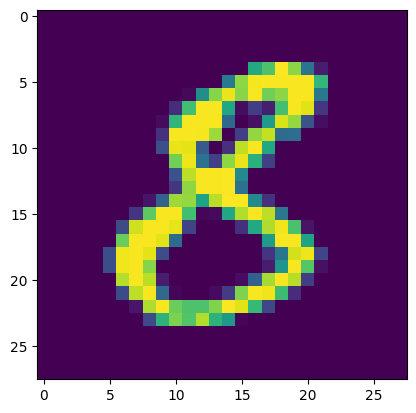

Nhãn dự đoán:  8
Nhãn ground-truth:  8


In [143]:
# Predict trên tập dữ liệu test
pred = lenet.predict(x_test_norm)
test_index = 1234
plt.imshow(x_test[test_index])
plt.show()
print('Nhãn dự đoán: ', np.argmax(pred[test_index]))
print('Nhãn ground-truth: ', y_test[test_index])

In [144]:
# Đánh giá hiệu quả của hệ thống trên tập test
lenet.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 930us/step
Độ chính xác của phiên bản hiện tại: 98.51999878883362


## 4. Thử nghiệm với một số biến thể

### 4.1 Biến thể Alpha - Thay activation `sigmoid` bằng `relu`

In [145]:
class AlphaCNN(LeNetCNN):
    # Define structure of the CNN
    def build(self, input_dim):
        input = Input(shape=input_dim)
        output = None
        ### BEGIN SOLUTION
        # Bước rút trích đặc trưng
        C1 = Conv2D(6, (3, 3), padding="same", activation="relu")(input)
        S2 = AveragePooling2D(pool_size=(2, 2), padding="same")(C1)
        C3 = Conv2D(16, (3, 3), padding="same", activation="relu")(S2)
        S4 = AveragePooling2D(pool_size=(2, 2), padding="same")(C3)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(S4)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, activation="relu", use_bias=True)(flat)
        F6 = Dense(84, activation="relu", use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output
        ### END SOLUTION
        self.model = Model(input, output)

In [146]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()
# Khởi tạo đối tượng mạng CNN kiến trúc Alpha
alpha = AlphaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
alpha.build((28, 28, 1))
alpha.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_19 (Aver  (None, 14, 14, 6)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 16)        880       
                                                                 
 average_pooling2d_20 (Aver  (None, 7, 7, 16)          0         
 agePooling2D)                                                   
                                                                 
 flatten_18 (Flatten)        (None, 784)               0  

In [147]:
# Kiểm tra kiến trúc Alpha
# Kiểm tra số layer không đổi
assert len(alpha.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng Alpha
assert "InputLayer" in str(type(alpha.model.layers[0]))
assert "Conv2D" in str(type(alpha.model.layers[1]))
assert "AveragePooling2D" in str(type(alpha.model.layers[2]))
assert "Dense" in str(type(alpha.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert alpha.model.layers[1].activation(1.0).numpy() == 1.0
assert alpha.model.layers[1].activation(-1.0).numpy() == 0.0

In [148]:
# Sau khi đã đảm bảo rằng kiến trúc của bạn đã ổn. Chờ gì nữa, train thôi!
alpha.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1635 - accuracy: 0.9486
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0584 - accuracy: 0.9824
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0461 - accuracy: 0.9857
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0400 - accuracy: 0.9873
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0292 - accuracy: 0.9911
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0315 - accuracy: 0.9908
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9910
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0285 - accuracy: 0.9915
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0268 - accuracy: 0.9923
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0248 - accuracy: 0.9930

In [149]:
# Đánh giá hiệu quả của mô hình trên tập test
alpha.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 831us/step
Độ chính xác của phiên bản hiện tại: 98.78000020980835


Theo bạn giữa phiên bản LeNet và Alpha, bạn thấy ĐỘ CHÍNH XÁC trên tập test của hai mô hình này có sự chênh lệch đáng kể hay không?

In [150]:
options = ['Không có ý kiến', 'LeNet tốt hơn Alpha', 'LeNet tệ hơn Alpha', 'LeNet ngang ngửa Alpha (chênh không quá 1%)']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 3
### END SOLUTION

print("Theo mình thì: ", options[your_choice])

Theo mình thì:  LeNet ngang ngửa Alpha (chênh không quá 1%)


Quan sát độ chính xác trên tập train của quá trình huấn luyện, theo bạn mô hình nào cho **tốc độ hội tụ** (*thể hiện tốc độ cải thiện độ chính xác qua từng epoch*) nhanh hơn?

In [151]:
options = ['Không có ý kiến', 'LeNet hội tụ nhanh hơn Alpha', 'LeNet hội tụ chậm hơn Alpha',
           'LeNet hội tụ nhanh ngang ngửa Alpha (tại epoch huấn luyện thứ 1 , chênh lệch acc không quá 5%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 2
### END SOLUTION

print("Theo mình thì: ", options[your_choice])

Theo mình thì:  LeNet hội tụ nhanh ngang ngửa Alpha (tại epoch huấn luyện thứ 1 , chênh lệch acc không quá 5%


### 4.2. Biến thể Beta - Thay AveragePooling bằng MaxPooling
Lưu ý rằng, biến thể `Beta` được phát triển tiếp từ biến thể `Alpha`, do đó cấu hình liên quan đến hàm activation cũng sử dụng `ReLU`

In [103]:
from keras.layers import MaxPooling2D


class BetaCNN(LeNetCNN):
    # Define structure of the CNN
    def build(self, input_dim):
        input = Input(shape=input_dim)
        output = None
        ### BEGIN SOLUTION
        # Bước rút trích đặc trưng
        C1 = Conv2D(6, (3, 3), padding="same", activation="relu")(input)
        S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(C1)
        C3 = Conv2D(16, (3, 3), padding="same", activation="relu")(S2)
        S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(C3)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(S4)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, activation="relu", use_bias=True)(flat)
        F6 = Dense(84, activation="relu", use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output
        ### END SOLUTION
        self.model = Model(input, output)

In [104]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Beta
beta = BetaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
beta.build((28, 28, 1))
beta.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 16)        880       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 784)               0  

In [105]:
# Kiểm tra kiến trúc Beta

# Kiểm tra số layer không đổi
assert len(beta.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng
assert "InputLayer" in str(type(beta.model.layers[0]))
assert "Conv2D" in str(type(beta.model.layers[1]))
assert "MaxPooling2D" in str(type(beta.model.layers[2]))
assert "Dense" in str(type(beta.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert beta.model.layers[1].activation(1.0).numpy() == 1.0
assert beta.model.layers[1].activation(-1.0).numpy() == 0.0

In [106]:
# Train đi, chờ chi!
beta.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1553 - accuracy: 0.9505
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0608 - accuracy: 0.9815
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0489 - accuracy: 0.9855
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0424 - accuracy: 0.9873
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0399 - accuracy: 0.9883
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0404 - accuracy: 0.9885
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0335 - accuracy: 0.9907
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9895
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0327 - accuracy: 0.9913
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0289 - accuracy: 0.9918

In [107]:
# Đánh giá trên tập dữ liệu test
beta.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 908us/step
Độ chính xác của phiên bản hiện tại: 98.65000247955322


Theo bạn giữa phiên bản Alpha và Beta, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [152]:
options = ['Không có ý kiến', 'Alpha tốt hơn Beta', 'Alpha tệ hơn Beta', 'Alpha ngang ngửa Beta (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 3
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Alpha ngang ngửa Beta (chênh không quá 1%)


Như vậy, đến bước này, bạn đã cài đặt xong mô hình LeNet theo hướng hiện đại, hay còn gọi là LeNet phiên bản 2020.

Không dừng lại ở đó, ta sẽ thử với một số biến thể táo bạo hơn.

### 4.3 Biến thể Gamma - Bỏ hết hàm activation trong biến thể Beta
Biến thể Gamma ra đời vì sự nghi ngờ rằng, **hàm activation không thực sự hữu ích** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

In [109]:
class GammaCNN(LeNetCNN):
    # Define structure of the CNN
    def build(self, input_dim):
        input = Input(shape=input_dim)
        output = None
        ### BEGIN SOLUTION
        # Bước rút trích đặc trưng
        C1 = Conv2D(6, (3, 3), padding="same")(input)
        S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(C1)
        C3 = Conv2D(16, (3, 3), padding="same")(S2)
        S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(C3)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(S4)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, use_bias=True)(flat)
        F6 = Dense(84,  use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output
        ### END SOLUTION

        self.model = Model(input, output)

In [110]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Gamma
gamma = GammaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
gamma.build((28, 28, 1))
gamma.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 16)        880       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 784)               0  

In [111]:
# Kiểm tra kiến trúc Gamma

# Kiểm tra số layer không đổi
assert len(gamma.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng
assert "InputLayer" in str(type(gamma.model.layers[0]))
assert "Conv2D" in str(type(gamma.model.layers[1]))
assert "MaxPooling2D" in str(type(gamma.model.layers[2]))
assert "Dense" in str(type(gamma.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert gamma.model.layers[1].activation(1.0) == 1.0
assert gamma.model.layers[1].activation(-1.0) == -1.0

In [112]:
# Train train train!
gamma.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2092 - accuracy: 0.9380
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1171 - accuracy: 0.9648
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0999 - accuracy: 0.9711
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0955 - accuracy: 0.9719
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0928 - accuracy: 0.9726
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1246 - accuracy: 0.9665
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0734 - accuracy: 0.9778
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0787 - accuracy: 0.9766
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1739 - accuracy: 0.9654
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1472 - accuracy: 0.9720

In [113]:
# Đánh giá trên tập dữ liệu test
gamma.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 958us/step
Độ chính xác của phiên bản hiện tại: 97.76999950408936


Theo bạn giữa phiên bản Beta và Gamma, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [153]:
options = ['Không có ý kiến', 'Beta tốt hơn Gamma', 'Beta tệ hơn Gamma', 'Beta ngang ngửa Gamma (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 3
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta tốt hơn Gamma


### 4.4 Biến thể Omicron - Bỏ hết hàm Pooling trong biến thể Beta
Biến thể **Omicron** ra đời vì sự nghi ngờ rằng, **Bước MaxPooling không thực sự hữu ích** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

In [117]:
class OmicronCNN(LeNetCNN):
    # Define structure of the CNN
    def build(self, input_dim):
        input = Input(shape=input_dim)
        output = None

        ### BEGIN SOLUTION
        # Bước rút trích đặc trưng
        C1 = Conv2D(6, (3, 3), padding="same", activation="relu")(input)
        C3 = Conv2D(16, (3, 3), padding="same", activation="relu")(C1)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(C3)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, activation="relu", use_bias=True)(flat)
        F6 = Dense(84, activation="relu", use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output
        ### END SOLUTION

        self.model = Model(input, output)

In [118]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Omicron
omicron = OmicronCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
omicron.build((28, 28, 1))
omicron.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 16)        880       
                                                                 
 flatten_15 (Flatten)        (None, 12544)             0         
                                                                 
 dense_45 (Dense)            (None, 120)               1505400   
                                                                 
 dense_46 (Dense)            (None, 84)                10164     
                                                                 
 dense_47 (Dense)            (None, 10)                850

In [119]:
# Kiểm tra kiến trúc Omicron

# Kiểm tra số layer không đổi
assert len(omicron.model.layers) == 7
# Kiểm tra một số lớp trong kiến trúc mạng
assert "InputLayer" in str(type(omicron.model.layers[0]))
assert "Conv2D" in str(type(omicron.model.layers[1]))
assert "Conv2D" in str(type(omicron.model.layers[2]))
assert "Dense" in str(type(omicron.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert beta.model.layers[1].activation(1.0).numpy() == 1.0
assert beta.model.layers[1].activation(-1.0).numpy() == 0.0

In [120]:
# Train train train!
omicron.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1837 - accuracy: 0.9445
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0640 - accuracy: 0.9805
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0408 - accuracy: 0.9876
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0427 - accuracy: 0.9874
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0326 - accuracy: 0.9907
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0316 - accuracy: 0.9916
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0334 - accuracy: 0.9913
Epoch 8/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0287 - accuracy: 0.9930
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0292 - accuracy: 0.9927
Epoch 10/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0287 - accura

In [121]:
# Đánh giá trên tập dữ liệu test
omicron.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 1ms/step
Độ chính xác của phiên bản hiện tại: 97.75000214576721


Theo bạn giữa phiên bản Beta và Omicron, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [154]:
options = ['Không có ý kiến', 'Beta tốt hơn Omicron', 'Beta tệ hơn Omicron', 'Beta ngang ngửa Omicron (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 3
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta tốt hơn Omicron


Ngoài ra, bạn có nhận xét gì về số lượng tham số và thời gian train của mô hình Omicron?

In [123]:
options = ['Omicron có tham số ít hơn Beta', 'Omicron nhiều tham số hơn Beta', 'Omicron có tham số bằng Beta',
           'Omicron train nhanh hơn Beta', 'Omicron train chậm hơn Beta', 'Omicron train tương đương Beta (không quá 10 giây)']

your_choices = []

# Hãy chọn your_choice với một TẬP CÁC GIÁ TRỊ từ 0, 1, 2, 3, 4, 5 tương ứng với các lựa chọn ở trên.
# LƯU Ý: Có thể chọn 0, 1 hoặc nhiều hơn 1 lựa chọn trong câu hỏi này
### BEGIN SOLUTION
your_choices = [2,5]
### END SOLUTION

print("Theo tôi thì: ")
for op in your_choices:
    print('   - ', options[op])

Theo tôi thì: 
   -  Omicron train tương đương Beta (không quá 10 giây)


### 4.5 Biến thể Delta - Bỏ hết lớp Convolution trong biến thể Beta
Biến thể **Delta** ra đời vì sự nghi ngờ rằng, **Bước Convolution không thực sự hữu ích!!!??** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

Biến thể này nguy hiểm, vì nó thay đổi hoàn toàn kiến trúc của mạng CNN. Theo bạn, biến thể Beta này bản chất là mô hình gì?

In [124]:
class DeltaCNN(LeNetCNN):
    # Define structure of the CNN
    def build(self, input_dim):
        input = Input(shape=input_dim)
        output = None
        ### BEGIN SOLUTION
        # Bước rút trích đặc trưng
        S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(input)
        S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(S2)
        # Bước trung gian chuyển từ tensor sang vector
        flat = Flatten()(S4)
        # Bước phân loại đặc trưng bước trước
        F5 = Dense(120, activation="relu", use_bias=True)(flat)
        F6 = Dense(84, activation="relu", use_bias=True)(F5)
        output = Dense(10, activation="softmax", use_bias=True)(F6)  # y~ output
        ### END SOLUTION

        self.model = Model(input, output)

In [125]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Omicron
delta = DeltaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
delta.build((28, 28, 1))
delta.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 1)         0         
 ng2D)                                                           
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 1)           0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 49)                0         
                                                                 
 dense_48 (Dense)            (None, 120)               6000      
                                                                 
 dense_49 (Dense)            (None, 84)                101

In [126]:
# Kiểm tra kiến trúc Delta

# Kiểm tra số layer không đổi
assert len(delta.model.layers) == 7
# Kiểm tra một số lớp trong kiến trúc mạng
assert "InputLayer" in str(type(delta.model.layers[0]))
assert "MaxPooling2D" in str(type(delta.model.layers[1]))
assert "MaxPooling2D" in str(type(delta.model.layers[2]))
assert "Dense" in str(type(delta.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert delta.model.layers[1].pool_size  == (2, 2)

In [127]:
# Trèn trén tren!
delta.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 1s 966us/step - loss: 0.5100 - accuracy: 0.8328
Epoch 2/10
469/469 [==============================] - 0s 953us/step - loss: 0.3633 - accuracy: 0.8797
Epoch 3/10
469/469 [==============================] - 0s 944us/step - loss: 0.3363 - accuracy: 0.8878
Epoch 4/10
469/469 [==============================] - 0s 933us/step - loss: 0.3196 - accuracy: 0.8921
Epoch 5/10
469/469 [==============================] - 0s 942us/step - loss: 0.3066 - accuracy: 0.8976
Epoch 6/10
469/469 [==============================] - 0s 1ms/step - loss: 0.2982 - accuracy: 0.9001
Epoch 7/10
469/469 [==============================] - 0s 958us/step - loss: 0.2910 - accuracy: 0.9029
Epoch 8/10
469/469 [==============================] - 0s 1ms/step - loss: 0.2870 - accuracy: 0.9047
Epoch 9/10
469/469 [==============================] - 0s 965us/step - loss: 0.2776 - accuracy: 0.9062
Epoch 10/10
469/469 [==============================] - 0s 1ms/step - loss: 0.2779 - ac

In [128]:
# Đánh giá trên tập dữ liệu test
delta.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 0s 362us/step
Độ chính xác của phiên bản hiện tại: 88.91000151634216


Theo bạn giữa phiên bản Delta và Beta, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [129]:
options = ['Không có ý kiến', 'Beta tốt hơn Delta', 'Beta tệ hơn Delta', 'Beta ngang ngửa Delta (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 1
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta ngang ngửa Delta (chênh không quá 1%)


Ngoài ra, bạn có nhận xét gì về số lượng tham số và thời gian train của mô hình Delta?

In [130]:
options = ['Delta có tham số ít hơn Beta', 'Delta nhiều tham số hơn Beta', 'Delta có tham số bằng Beta',
           'Delta train nhanh hơn Beta', 'Delta train chậm hơn Beta', 'Delta train tương đương']

your_choices = []

# Hãy chọn your_choice với một TẬP CÁC GIÁ TRỊ từ 0, 1, 2, 3, 4, 5 tương ứng với các lựa chọn ở trên
# LƯU Ý: Có thể chọn 0, 1 hoặc nhiều hơn 1 lựa chọn trong câu hỏi này
### BEGIN SOLUTION
your_choices = [1,3]
### END SOLUTION

print("Theo tôi thì: ")
for op in your_choices:
    print('   - ', options[op])

Theo tôi thì: 
   -  Delta train tương đương


Phew!! Vậy là bạn đã trải nghiệm **cảm giác thiết kế, chỉnh sửa kiến trúc** mạng CNN. Mỗi module đều có một chức năng nhất định. Hi vọng bạn cảm nhận được ý nghĩa của từng module và vai trò của nó trong thiết kế chung của mạng CNN.